## 모델 개선
- 과대적합 방지 - 학습 파라미터 수 축소
- 모델 성능 높이기 - 레이어 추가
- 모델 성능 높이기 - 이미지 증식

In [ ]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
from keras import Model
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, SpatialDropout2D, Flatten, Reshape, Input
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from keras.datasets.fashion_mnist import load_data
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
(x_train,y_train),(x_test,y_test) = load_data()
x_train = x_train[...,np.newaxis] # 이미지 데이터에 채널 차원이 명시적으로 없는 경우(예: (28, 28) 크기의 MNIST 이미지) 채널 차원을 추가하기 위해 사용
x_test = x_test[...,np.newaxis]

x_train = x_train/255.
x_test = x_test/255.

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [ ]:
class_names = ['T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

In [ ]:
# 모델 구성 및 컴파일
def build_model():
  # model=Sequential()
  input = Input(shape=(28,28,1))
  output = Conv2D(filters=32,kernel_size=(3,3))(input)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Flatten()(output)
  output = Dense(128, activation='relu')(output)
  output = Dense(64, activation='relu')(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  return model

model_1 = build_model()
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 30976)             0         
                                                                 
 dense (Dense)               (None, 128)               3965056   
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [ ]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model.h5', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_1 = model_1.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
329/329 [==============================] - ETA: 0s - loss: 0.4947 - acc: 0.8236
Epoch 1: val_loss improved from inf to 0.38875, saving model to best_model.h5
329/329 [==============================] - 8s 8ms/step - loss: 0.4947 - acc: 0.8236 - val_loss: 0.3887 - val_acc: 0.8622
Epoch 2/40
 14/329 [>.............................] - ETA: 1s - loss: 0.3429 - acc: 0.8806

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


318/329 [===========================>..] - ETA: 0s - loss: 0.3407 - acc: 0.8759
Epoch 2: val_loss improved from 0.38875 to 0.34962, saving model to best_model.h5
329/329 [==============================] - 2s 5ms/step - loss: 0.3406 - acc: 0.8758 - val_loss: 0.3496 - val_acc: 0.8734
Epoch 3/40
329/329 [==============================] - ETA: 0s - loss: 0.2846 - acc: 0.8946
Epoch 3: val_loss did not improve from 0.34962
329/329 [==============================] - 2s 5ms/step - loss: 0.2846 - acc: 0.8946 - val_loss: 0.3744 - val_acc: 0.8739
Epoch 4/40
326/329 [============================>.] - ETA: 0s - loss: 0.2398 - acc: 0.9117
Epoch 4: val_loss did not improve from 0.34962
329/329 [==============================] - 2s 5ms/step - loss: 0.2397 - acc: 0.9118 - val_loss: 0.3769 - val_acc: 0.8737
Epoch 5/40
327/329 [============================>.] - ETA: 0s - loss: 0.2051 - acc: 0.9236
Epoch 5: val_loss did not improve from 0.34962
329/329 [==============================] - 2s 5ms/step - loss

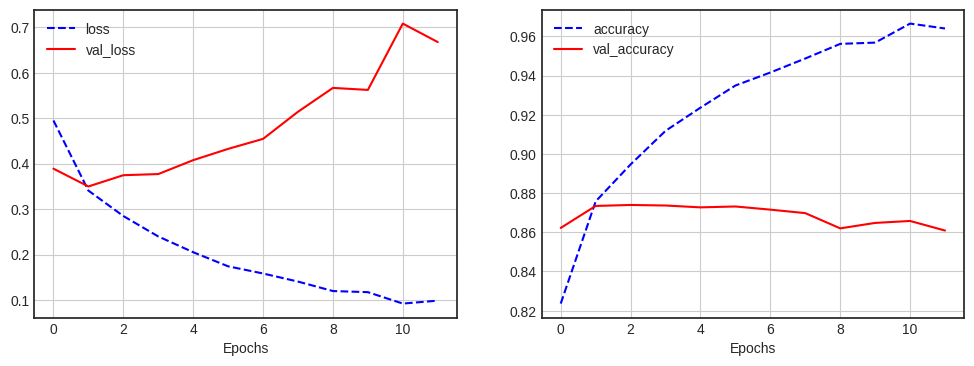

In [ ]:
hist_1.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_1.history['loss'],'b--',label='loss')
plt.plot(hist_1.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_1.history['acc'],'b--',label='accuracy')
plt.plot(hist_1.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()
# loss 와 val_loss 가 격차가 처음부터 나는데, 이것은 과대적합이 있음을 의미함.

In [ ]:
model_1.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.7305 - acc: 0.8538


[0.7305119633674622, 0.8537999987602234]

### 모델 구성 및 학습: 과대적합 방지

- 학습 파라미터의 수 비교

In [ ]:
# 슬림한 모델로 바꾼 결과 과적합은 방지하지만 성능은 좋지 않음
def build_model2():

  input = Input(shape=(28,28,1))
  output = Conv2D(filters=32,kernel_size=(3,3))(input)
  output = MaxPooling2D(strides=(2,2))(output)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Dropout(0.4)(output)
  output = MaxPooling2D(strides=(2,2))(output)
  output = Conv2D(filters=64,kernel_size=(3,3))(output)
  output = Dropout(0.4)(output)
  output = MaxPooling2D(strides=(2,2))(output)
  output = Flatten()(output)
  output = Dense(128, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(64, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  return model

model_2 = build_model2()
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 11, 11, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                      

In [ ]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model2.h5', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_2 = model_2.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
329/329 [==============================] - ETA: 0s - loss: 1.1577 - acc: 0.5703
Epoch 1: val_loss improved from inf to 0.72322, saving model to best_model2.h5
329/329 [==============================] - 5s 7ms/step - loss: 1.1577 - acc: 0.5703 - val_loss: 0.7232 - val_acc: 0.7455
Epoch 2/40
321/329 [============================>.] - ETA: 0s - loss: 0.7324 - acc: 0.7355
Epoch 2: val_loss improved from 0.72322 to 0.60169, saving model to best_model2.h5
329/329 [==============================] - 2s 5ms/step - loss: 0.7301 - acc: 0.7362 - val_loss: 0.6017 - val_acc: 0.7740
Epoch 3/40
326/329 [============================>.] - ETA: 0s - loss: 0.6546 - acc: 0.7682
Epoch 3: val_loss improved from 0.60169 to 0.56538, saving model to best_model2.h5
329/329 [==============================] - 2s 6ms/step - loss: 0.6540 - acc: 0.7683 - val_loss: 0.5654 - val_acc: 0.7918
Epoch 4/40
319/329 [============================>.] - ETA: 0s - loss: 0.6023 - acc: 0.7879
Epoch 4: val_loss improved f

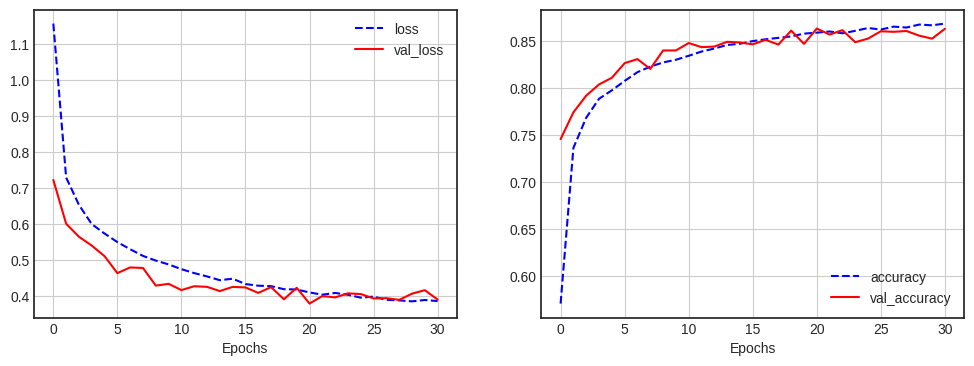

In [ ]:
hist_2.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_2.history['loss'],'b--',label='loss')
plt.plot(hist_2.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_2.history['acc'],'b--',label='accuracy')
plt.plot(hist_2.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()
# 파라미터수를 백만개에서 7만개 정도로 확 낮추니, 과대 적합문제가 해결된 것을 볼 수 있음.

In [ ]:
model_2.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4103 - acc: 0.8576


[0.4102931022644043, 0.8575999736785889]

### 모델 성능 높이기: 레이어 추가

In [ ]:
def build_model3():

  input = Input(shape=(28,28,1))
  output = Conv2D(filters=64,kernel_size=3, activation='relu',padding='same')(input)
  output = BatchNormalization()(output)
  output = Conv2D(filters=64,kernel_size=3, activation='relu',padding='valid')(output)
  output = Dropout(0.5)(output)
  output = MaxPooling2D(strides=(2,2))(output)

  output = Conv2D(filters=128,kernel_size=3, activation='relu',padding='same')(output)
  output = BatchNormalization()(output)
  output = Conv2D(filters=128,kernel_size=3, activation='relu',padding='valid')(output)
  output = Dropout(0.5)(output)
  output = MaxPooling2D(strides=(2,2))(output)

  output = Conv2D(filters=256,kernel_size=3, activation='relu',padding='same')(output)
  output = BatchNormalization()(output)
  output = Conv2D(filters=256,kernel_size=3, activation='relu',padding='valid')(output)
  output = Dropout(0.5)(output)
  output = MaxPooling2D(strides=(2,2))(output)

  output = Flatten()(output)
  output = Dense(512, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(256, activation='relu')(output)
  output = Dropout(0.5)(output)
  output = Dense(10, activation='softmax')(output)

  model = Model(inputs=[input], outputs=output)

  model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['acc'])
  return model

model_3 = build_model3()
model_3.summary()
# 파라미터 140만개로 늘어남.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_3 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 dropout_9 (Dropout)         (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                      

In [ ]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model3.h5', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_3 = model_3.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
329/329 [==============================] - ETA: 0s - loss: 0.7783 - acc: 0.7186
Epoch 1: val_loss improved from inf to 2.19530, saving model to best_model3.h5
329/329 [==============================] - 9s 12ms/step - loss: 0.7783 - acc: 0.7186 - val_loss: 2.1953 - val_acc: 0.2083
Epoch 2/40
323/329 [============================>.] - ETA: 0s - loss: 0.4529 - acc: 0.8390
Epoch 2: val_loss improved from 2.19530 to 1.13491, saving model to best_model3.h5
329/329 [==============================] - 3s 9ms/step - loss: 0.4526 - acc: 0.8392 - val_loss: 1.1349 - val_acc: 0.6387
Epoch 3/40
329/329 [==============================] - ETA: 0s - loss: 0.3679 - acc: 0.8726
Epoch 3: val_loss improved from 1.13491 to 0.75901, saving model to best_model3.h5
329/329 [==============================] - 3s 9ms/step - loss: 0.3679 - acc: 0.8726 - val_loss: 0.7590 - val_acc: 0.8351
Epoch 4/40
326/329 [============================>.] - ETA: 0s - loss: 0.3332 - acc: 0.8850
Epoch 4: val_loss did not i

- 과대적합은 되지 않았고, 층을 늘려도 좋은 성능을 낼 수 있음

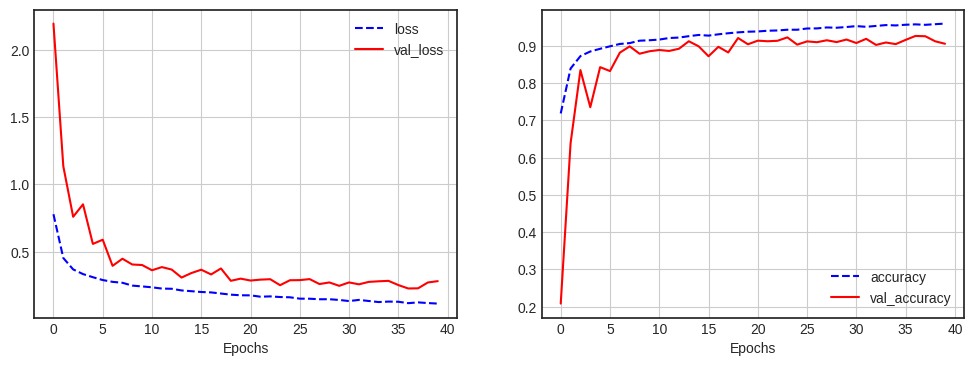

In [ ]:
hist_3.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_3.history['loss'],'b--',label='loss')
plt.plot(hist_3.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_3.history['acc'],'b--',label='accuracy')
plt.plot(hist_3.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model_3.evaluate(x_test,y_test)
# 값이 loss가 2.3, acc가 0.02가 나오는데..
# Epoch 40: val_loss did not improve from 0.22622
# 329/329 [==============================] - 3s 8ms/step - loss: 0.1138 - acc: 0.9599 - val_loss: 0.2806 - val_acc: 0.9057
# 이것에 맞게끔 나와야하는데 뭔가 충돌이 있는듯.

313/313 [==============================] - 1s 3ms/step - loss: 2.3031 - acc: 0.0283


[2.3031442165374756, 0.028300000354647636]

In [ ]:
!ls

best_model2.h5	best_model3.h5	best_model.h5  sample_data


### CNN(Convolutional Neural Network)에서 파라미터 수의 증가 요소

- 필터(커널)의 수: CNN의 각 합성곱 계층(Convolutional layer)은 여러 필터(또는 커널)를 사용하여 입력 이미지에서 특징을 추출합니다. 필터의 수가 많아질수록 더 많은 특징을 동시에 학습할 수 있지만, 이는 동시에 해당 계층의 파라미터 수를 증가시킵니다.

- 필터의 크기: 필터의 크기가 클수록 한 번에 더 넓은 영역의 정보를 처리할 수 있습니다. 그러나 필터 크기의 증가는 필터 내의 가중치 수를 증가시켜, 결과적으로 해당 계층의 전체 파라미터 수를 증가시킵니다.

- 완전연결계층(Fully Connected layers)의 크기: CNN의 끝부분에서 주로 사용되는 전결합 계층은 모든 입력을 각 출력 뉴런에 연결합니다. 이 계층의 뉴런(유닛) 수가 많을수록 모델의 파라미터 수가 크게 증가합니다. 전결합 계층은 일반적으로 모델 내에서 가장 많은 파라미터를 가집니다.

- 계층의 깊이: CNN의 계층(레이어) 수가 많아질수록, 즉 모델이 더 깊어질수록, 모델이 더 복잡한 특징을 학습할 수 있게 되지만, 이는 또한 전체 파라미터 수를 증가시킵니다.

- 특성 맵(Feature Map)의 크기: 특정 합성곱 계층이 출력하는 특성 맵의 크기가 크면 클수록, 그 다음 계층(특히 전결합 계층이나 합성곱 계층)의 파라미터 수가 증가할 수 있습니다. 특성 맵의 크기는 입력 이미지의 크기와 필터의 크기, 스트라이드(stride), 패딩(padding)에 의해 결정됩니다.

이러한 요소들은 모두 모델의 학습 능력과 일반화 능력에 영향을 미칩니다. 파라미터 수가 많은 모델은 더 복잡한 특징을 학습할 수 있지만, 과적합(overfitting)의 위험도 높아질 수 있습니다. 반면, 파라미터 수가 적은 모델은 계산 효율성은 높지만, 모델의 표현 능력이 제한될 수 있습니다. 따라서 모델 설계 시 이러한 점을 고려하여 적절한 균형을 찾는 것이 중요합니다.

### 모델 성능 높이기: 이미지 증강(Image Augmentation)
데이터 증강은 기존의 훈련 데이터를 다양하게 변형하여 모델의 일반화 능력을 향상시키는 기법입니다. 각 파라미터는 특정 방식으로 이미지를 변형합니다.

ImageDataGenerator 파라미터 설명:
- rotation_range=10: 이미지를 -10도에서 10도 사이로 무작위로 회전합니다.
- zoom_range=0.2: 이미지를 80%에서 120% 사이로 무작위로 확대/축소합니다.
- shear_range=0.6: 이미지를 반시계 방향으로 0.6 라디안 내에서 기울입니다.
- width_shift_range=0.1와 height_shift_range=0.1: 각각 이미지를 수평과 수직으로 최대 10% 내에서 무작위로 이동합니다.
- horizontal_flip=True: 수평 방향으로 이미지를 무작위로 뒤집습니다. (예: 좌우 반전)
- vertical_flip=False: 수직 방향으로 이미지를 뒤집지 않습니다.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.6,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
augment_size = 200 # 데이터 증강을 통해 생성하고자 하는 증강된 이미지의 수
print(x_train.shape)
print(x_train[0].shape)

(60000, 28, 28, 1)
(28, 28, 1)


In [ ]:
# flow 메소드는 실제로 이미지 데이터를 변환하는 작업을 수행
# np.tile(x_train[0].reshape(28*28*1),augment_size).reshape(-1,28,28,1)은 첫 번째 훈련 이미지(x_train[0])를 augment_size(200)만큼 복제하여 증강된 이미지 데이터의 형태로 변환.
# np.zeros(augment_size)는 증강된 이미지에 대한 레이블을 생성
# batch_size=augment_size는 한 번에 생성할 증강된 이미지의 수를 지정
# next()[0]을 통해 생성된 이미지 배치 중 첫 번째 배치(즉, 증강된 이미지들)에 접근
x_augment = image_generator.flow(np.tile(x_train[0].reshape(28*28*1),augment_size).reshape(-1,28,28,1),
                            np.zeros(augment_size), batch_size=augment_size, shuffle=False).next()[0]

In [ ]:
x_augment.shape

(200, 28, 28, 1)

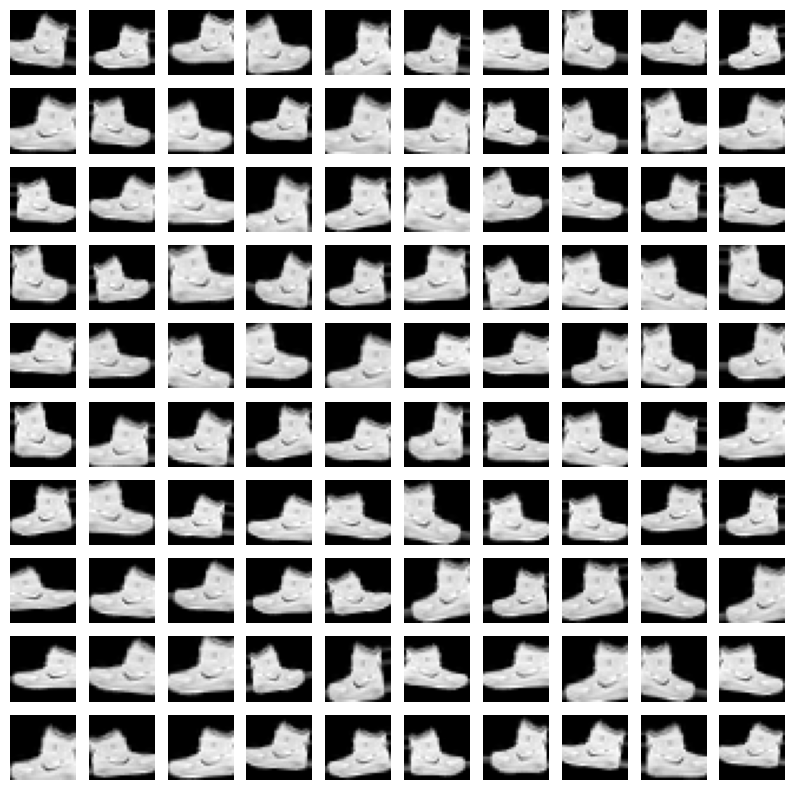

In [ ]:
plt.figure(figsize=(10,10))
for i in range(1,101):
  plt.subplot(10,10,i)
  plt.axis('off')
  plt.imshow(x_augment[i-1].reshape(28,28),cmap='gray')

In [ ]:
image_generator = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    shear_range=0.6,
    width_shift_range=0.15,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)
augment_size = 30000
random_mask = np.random.randint(x_train.shape[0],size=augment_size)
x_augmented = x_train[random_mask].copy()
y_augmented = y_train[random_mask].copy()

In [ ]:
x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size),
                                   batch_size=augment_size, shuffle=False).next()[0]

In [ ]:
x_augmented.shape

(30000, 28, 28, 1)

In [ ]:
x_train = np.concatenate((x_train,x_augmented))
y_train = np.concatenate((y_train,y_augmented))
print(x_train.shape)
print(y_train.shape)

(90000, 28, 28, 1)
(90000,)


In [ ]:
model_4 = build_model3()
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_6 (Bat  (None, 28, 28, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_19 (Conv2D)          (None, 26, 26, 64)        36928     
                                                                 
 dropout_14 (Dropout)        (None, 26, 26, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 13, 13, 64)        0         
 g2D)                                                      

In [ ]:
# ModelCheckpoint 콜백 설정
model_checkpoint = ModelCheckpoint(
    'best_model4.h5', # 모델 파일 경로
    monitor='val_loss', # 모니터링 대상 성능 지표
    verbose=1, # 로그를 출력
    save_best_only=True, # 가장 좋은 모델만 저장
)

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss', # 모니터링 대상 성능 지표
    patience=10, # 성능 개선이 없는 에폭을 몇 번까지 허용할지 설정
    verbose=1, # 로그를 출력
)

# 학습 실행
hist_4 = model_4.fit(
    x_train, y_train,
    epochs=40,
    validation_split=0.3,
    batch_size=128,
    callbacks=[model_checkpoint, early_stopping] # 콜백 리스트에 추가
)

Epoch 1/40
493/493 [==============================] - ETA: 0s - loss: 0.6868 - acc: 0.7539
Epoch 1: val_loss improved from inf to 2.07668, saving model to best_model4.h5
493/493 [==============================] - 9s 11ms/step - loss: 0.6868 - acc: 0.7539 - val_loss: 2.0767 - val_acc: 0.1892
Epoch 2/40
492/493 [============================>.] - ETA: 0s - loss: 0.4112 - acc: 0.8568
Epoch 2: val_loss improved from 2.07668 to 1.19193, saving model to best_model4.h5
493/493 [==============================] - 4s 8ms/step - loss: 0.4116 - acc: 0.8567 - val_loss: 1.1919 - val_acc: 0.6468
Epoch 3/40
487/493 [============================>.] - ETA: 0s - loss: 0.3577 - acc: 0.8756
Epoch 3: val_loss did not improve from 1.19193
493/493 [==============================] - 4s 9ms/step - loss: 0.3573 - acc: 0.8758 - val_loss: 1.2936 - val_acc: 0.6245
Epoch 4/40
486/493 [============================>.] - ETA: 0s - loss: 0.3215 - acc: 0.8888
Epoch 4: val_loss improved from 1.19193 to 1.02274, saving mode

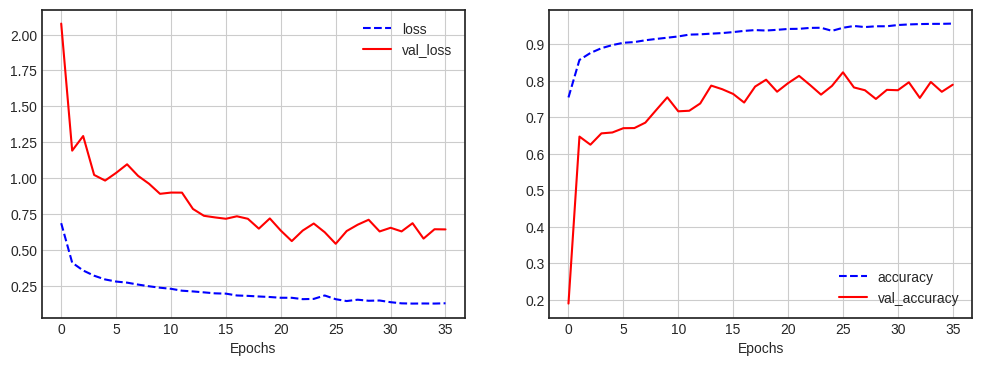

In [ ]:
hist_4.history.keys()
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(hist_4.history['loss'],'b--',label='loss')
plt.plot(hist_4.history['val_loss'],'r',label='val_loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_4.history['acc'],'b--',label='accuracy')
plt.plot(hist_4.history['val_acc'],'r',label='val_accuracy')
plt.xlabel('Epochs')
plt.grid()
plt.legend()

plt.show()

In [ ]:
model_4.evaluate(x_test,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.2452 - acc: 0.9187


[0.24523240327835083, 0.9186999797821045]

# 합성곱 신경망의 시각화

In [ ]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다.
import tensorflow as tf

tf.keras.utils.set_random_seed(42) # TensorFlow의 난수 생성기에 대한 글로벌 랜덤 시드를 설정
tf.config.experimental.enable_op_determinism() # TensorFlow가 가능한 한 결정적인 연산을 사용하도록 강제

## 가중치 시각화

In [ ]:
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# local 폴더에서 가져오는 경우. colab이아닌(drive) 로컬에 있다면 업로드해서 모델을 가져올 수 있음
# from google.colab import files
# files.upload()

{}

In [ ]:
!ls

drive  sample_data


In [ ]:
# 웹에서 모델 다운해서 사용하기
# 코랩에서 실행하는 경우에는 다음 명령을 실행하여 best-cnn-model.h5 파일을 다운로드받아 사용하세요.
# !wget https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.h5

--2023-11-11 04:03:47--  https://github.com/rickiepark/hg-mldl/raw/master/best-cnn-model.h5
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.h5 [following]
--2023-11-11 04:03:48--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/best-cnn-model.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4046712 (3.9M) [application/octet-stream]
Saving to: ‘best-cnn-model.h5’

best-cnn-model.h5   100%[===================>]   3.86M  --.-KB/s    in 0.06s   

2023-11-11 04:03:48 (60.6 MB/s) - ‘best-cnn-model.h5’ saved [4046712/4046712]



In [ ]:
# 우리는 구글 드라이브에 저장해놓았기 때문에 그 경로를 줘서 불러옴.
model = keras.models.load_model('/content/drive/MyDrive/hjh_kita_directory/Github/kita_231026/m8_vision/best-cnn-model.h5')

In [ ]:
model.layers

In [ ]:
# 신경망 모델의 첫 번째 레이어(여기서는 합성곱 레이어를 가정)의 가중치(weights)와 편향(biases)의 형태(shape)를 확인
# 편향은 각 출력 채널에 대해 하나씩, 총 32개가 존재
conv = model.layers[0] # 첫번째 레이어의 첫번째 가중치를 보면,

print(conv.weights[0].shape, conv.weights[1].shape) # (높이, 너비, 입력 채널 수, 출력 채널 수) (출력 채널 수,)

(3, 3, 1, 32) (32,)


In [ ]:
conv_weights = conv.weights[0].numpy()
# 모델의 초기화 상태를 평가하거나, 훈련 과정 중 가중치 값들이 어떻게 변화하는지 관찰하는 데 유용할 수 있습니다.
# 예를 들어, 가중치의 초기화가 너무 작거나 큰 값을 가지면, 학습 과정에 부정적인 영향을 미칠 수 있습니다.
print(conv_weights.mean(), conv_weights.std())
# 평균과 표준편차. 상당히 고르게 되어있음

-0.017149674 0.23305678


In [ ]:
import matplotlib.pyplot as plt

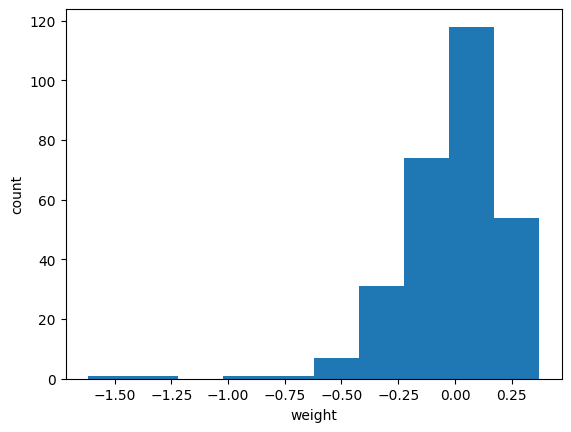

In [ ]:
plt.hist(conv_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

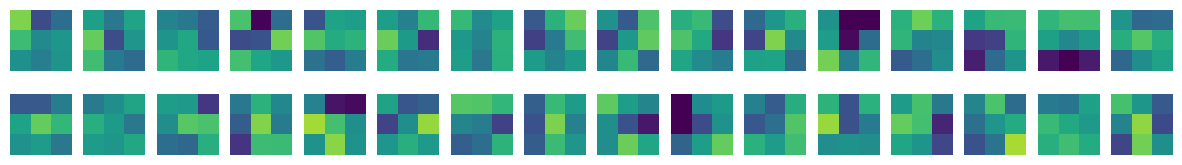

In [ ]:
# 합성곱 레이어의 첫 번째 입력 채널에 대한 모든 필터를 2행 16열의 격자 형태로 시각화, 각 필터가 어떤 특징을 감지하도록 학습되었는지 직관적으로 이해할 수 있게한다.
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
      # vmin=-0.5, vmax=0.5 색상 맵에 사용될 데이터의 값 범위를 지정. 가중치 값의 범위를 -0.5에서 0.5로 설정하여 시각화의 색상 대비를 조절
        axs[i, j].imshow(conv_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5) # i*16 + j는 출력 채널(또는 필터)의 인덱스를 계산하는 부분
        axs[i, j].axis('off')

plt.show()

시각화 결과로 부터 가중치 값이 무작위로 나열된 것이 아닌 어떤 패턴을 볼 수 있다. 예를들어 밝은 부분의 값이 높으며 이 가중치는 오른쪽에 놓인 직선을 만나면 크게 활성화 될 수 있다.(가중치가 높으면 더 활성화가 될 것)

In [ ]:
# 가중치가 초기화된 상태이지만 아직 학습되지 않은 새로운 합성곱 신경망 모델을 생성하고,
# 이 모델에 첫 번째 레이어로 합성곱 레이어(Conv2D)를 추가하는 과정
no_training_model = keras.Sequential()

no_training_model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',
                                          padding='same', input_shape=(28,28,1)))

In [ ]:
no_training_conv = no_training_model.layers[0]

print(no_training_conv.weights[0].shape)

(3, 3, 1, 32)


In [ ]:
no_training_weights = no_training_conv.weights[0].numpy()

print(no_training_weights.mean(), no_training_weights.std())

-0.0016975602 0.08003447


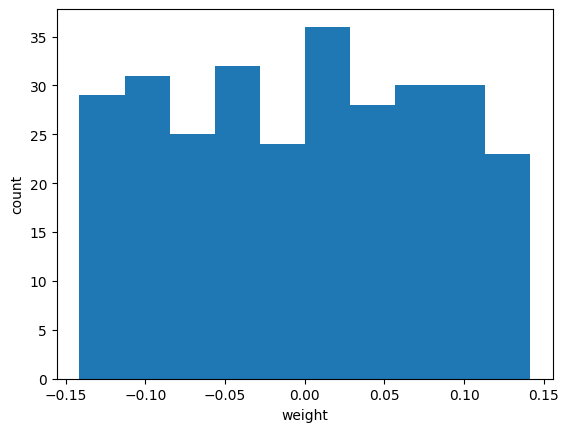

In [ ]:
plt.hist(no_training_weights.reshape(-1, 1))
plt.xlabel('weight')
plt.ylabel('count')
plt.show()

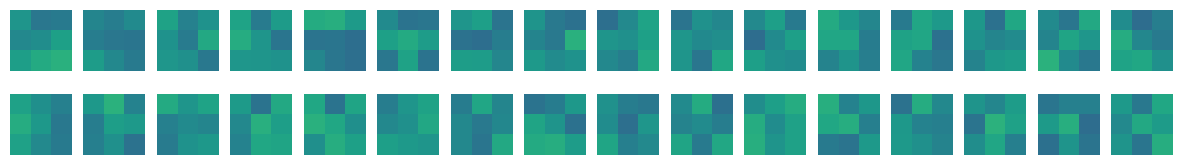

In [ ]:
# 전체적으로 가중치가 밋밋하게 초기화
fig, axs = plt.subplots(2, 16, figsize=(15,2))

for i in range(2):
    for j in range(16):
        axs[i, j].imshow(no_training_weights[:,:,0,i*16 + j], vmin=-0.5, vmax=0.5)
        axs[i, j].axis('off')

plt.show()

학습을 거친 이전 가중치와 비교하면 합성곱 신경만이 패션 MNIST 데이터셋의 분류 정확도를 높이기 위해 유용한 패턴을 학습했다는 사실을 확인할 수 있다.

## 함수형 API

In [ ]:
dense1 = keras.layers.Dense(100, activation='sigmoid')
dense2 = keras.layers.Dense(10, activation='softmax')
inputs = keras.Input(shape=(784,))

In [ ]:
hidden = dense1(inputs)
outputs = dense2(hidden)
model = keras.Model(inputs, outputs)

In [ ]:
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
conv_acti = keras.Model(model.input, model.layers[0].output)
conv_acti.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
